<h1><center>Final Tutorial Notebook</center></h1>
<h3><center>Emily Gong, Robert Morrison</center></h3>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Flag_of_the_United_Nations_%281945-1947%29.svg/2000px-Flag_of_the_United_Nations_%281945-1947%29.svg.png" width="600">

# Outline
- ### Introduction
    - Overview
    - Tools
- ### Data Collection
    - Loading Data
    - Scraping Data  

- ### Exploratory Data Analysis
    - Explore Countries
    - Explore Votes
    - Explore Words
    - Explore Entities
    - Explore Topics 
- ### Analysis & ML
    - t-SNS
- ### Conclusions and Further Actions
    - Challenges
    - Conclusions
    - Additional Resources

# Introduction

## Overview
**Background:**  
The United Nations is an international organization of independent states to promote peace and international cooperation and security. Currently, there are 193 sovereign states and they meet every year in regular session on the Tuesday of the third week in September. Every year, the UN creates a theme to focus on. Interestingly, this year’s theme is “Making the United Nations relevant to all people: global leadership and shared responsibilities for peaceful, equitable and sustainable societies”. In this notebook we are taking up the challenge of making the UN relevant by exploring the transcripts from the general debates and the votes from each country. 

**Purpose:**  
The original intention was to look at the transcripts from the debate and predict the country the speaker was from. However, after analyzing the dataset there were challenges that redirected us to find a different purpose. These challenges are mentioned later. After reevaluating, we have decided to ... {UPDATE TEXT HERE}


**Datasets:**
- The UN General Debates dataset includes the general debates at the UN from 1970 - 2016. Information such as the session ID, year, country (ISO 3166 Alpha-3 country code 1), and transcription is included. 
    - https://www.kaggle.com/unitednations/un-general-debates?fbclid=IwAR3Onf0CDZsw-dCwNlmj85hfvq12KavEpkyIkKN-FGguAuIyzpaqwvREhC0

- The UN General Assembly Votes dataset includes three separate csvs, resolutions, states, and votes. This dataset ranges from 1946-2015 and contains the votes of each country during various years. Specifically, it contains votes relating to topics such as human rights, nuclear development, and a few other categories. 
    - https://www.kaggle.com/unitednations/general-assembly


**Personal Investment:**  
On a personal level, we are interested in looking at this data because there are a lot of tools relating to NLP and we are interested in utilizing these tools to better understand what has been developed to process language. (Note Emily is a Computer Science and Linguistics Major). 


## Tools
**Processing**  
- NLTK
    - suite of libraries for working with human language
    - use cases:
        - tokenization: separate corpra by tokens (words)
        - part of speech tagging: label the type of speech
        - chunking: segments and labels multi-token sequences
    - widely used for teaching and research
- spaCy
    - advance library to implement nlp
    - use cases:
        - entity detection
            - model of English
    - widely used for production usage

**Visualization** 
- gensim
    - visualizing topic models
- pyLDAvis
    - visualizing topic models
- bokeh
    - Visualizing LDA results 

**Imports**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import random


# regular expressions
import re

# scraping 
import requests
import bs4

# processing
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from spacy import displacy #display word entities
import en_core_web_sm #language model
from collections import Counter
nlp = en_core_web_sm.load() 
from nltk.stem.wordnet import WordNetLemmatizer

# Below are libraries for LDA using gensim which is provides less control 
from nltk.corpus import stopwords #stop words to be filited out
from gensim import models, corpora  #Used for LDA topic modeling
from sklearn.metrics.pairwise import euclidean_distances 
import pyLDAvis.gensim #python library for interactive topic model visualization
from sklearn.manifold import TSNE

import lda

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

pyLDAvis.enable_notebook()

# evaluating the model
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#Below are libraries for LDA using sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# voting 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Loading BokehJS ...

# Loading Data
## Raw Data

#### Debate Data

In [2]:
debates = pd.read_csv("un-general-debates.csv")
debates.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [73]:
sample_debates = pd.DataFrame()
sample_debates['text'] = np.nan
temp_list = []
temp_year = []
for i in range(100):
    index = random.randint(0, len(debates))
    temp_list.append(debates.loc[index]['text'])
    temp_year.append(debates.loc[index]['year'])
sample_debates['text'] = temp_list
sample_debates['year'] = temp_year

In [75]:
print(len(debates))

7507


In [76]:
countries = debates["country"].unique()
print(countries)
print(len(countries))

['MDV' 'FIN' 'NER' 'URY' 'ZWE' 'PHL' 'SDN' 'RUS' 'CHN' 'ESP' 'SUR' 'ARG'
 'SLV' 'MYS' 'NPL' 'PRT' 'COL' 'BLR' 'MAR' 'LCA' 'EGY' 'MEX' 'BEL' 'BRN'
 'RWA' 'CAN' 'ALB' 'GRC' 'KNA' 'GUY' 'LBR' 'ATG' 'MOZ' 'JPN' 'YDYE' 'GAB'
 'BGD' 'SWE' 'TUR' 'TCD' 'SYR' 'CMR' 'JAM' 'LUX' 'ITA' 'AGO' 'CRI' 'CSK'
 'BFA' 'MNG' 'BHR' 'HTI' 'OMN' 'CIV' 'TGO' 'CYP' 'MUS' 'MMR' 'ARE' 'GTM'
 'GRD' 'LBY' 'LKA' 'TZA' 'SGP' 'NOR' 'LAO' 'ISL' 'AFG' 'CHL' 'DMA' 'UKR'
 'KEN' 'BLZ' 'FRA' 'MLI' 'VCT' 'VEN' 'MLT' 'GHA' 'GIN' 'GBR' 'ISR' 'YUG'
 'BRB' 'IRQ' 'HUN' 'AUT' 'POL' 'GNB' 'BWA' 'MRT' 'SWZ' 'DNK' 'DOM' 'MDG'
 'NIC' 'BDI' 'CUB' 'IRN' 'PAK' 'SEN' 'BGR' 'YEM' 'STP' 'NLD' 'VUT' 'BOL'
 'PNG' 'SLB' 'DEU' 'ROU' 'KHM' 'TUN' 'BRA' 'IND' 'IDN' 'AUS' 'COD' 'HND'
 'GNQ' 'FJI' 'IRL' 'DZA' 'USA' 'LSO' 'GMB' 'PER' 'DDR' 'THA' 'JOR' 'COG'
 'NGA' 'ECU' 'SAU' 'QAT' 'SYC' 'ETH' 'TTO' 'PRY' 'VNM' 'NZL' 'PAN' 'MWI'
 'DJI' 'BEN' 'SOM' 'ZMB' 'CPV' 'BHS' 'KWT' 'UGA' 'COM' 'ZAF' 'LBN' 'SLE'
 'KOR' 'BIH' 'TON' 'EU' 'HRV' 'NRU' 'TUV' 'NAM' 'S

In [77]:
years = debates["year"].unique()
print(years)
print(len(years))
# 46 Examples of each country

[1989 1970 2013 1985 2008 1991 1986 2002 1975 1996 2012 1997 1978 1988
 2010 1984 1995 2009 1971 1976 1983 1979 1999 2005 1987 1982 1998 2003
 2004 1980 2014 2011 1974 2015 1993 1977 1981 2000 1992 1990 1973 1994
 1972 2006 2007 2001]
46


#### Voting Data

In [78]:
# Notes
resolutions = pd.read_csv("resolutions.csv")

# Notes
# - Germany gets split into East and West (Called German Federal Republic and German Democratic Republic respectively)
# - Modern Germany keeps the name German Federal Republic
states = pd.read_csv("states.csv")

# Notes 
votes = pd.read_csv("votes.csv")

In [79]:
resolutions.head()

,assembly_session,vote_id,resolution,amendment,vote_date,significant_vote,yes_votes,no_votes,abstain,colonization,human_rights,israel_palestine,disarmament,nuclear_weapons,economic_development
0,1,3,R/1/66,1.0,1/1/1946,0,29,18,4,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4,R/1/79,0.0,1/2/1946,0,9,34,8,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,R/1/98,0.0,1/4/1946,0,28,22,1,0.0,0.0,0.0,0.0,0.0,0.0
3,1,6,R/1/107,0.0,1/4/1946,0,12,27,10,0.0,1.0,0.0,0.0,0.0,0.0
4,1,7,R/1/295,1.0,1/2/1946,0,25,18,0,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
resolutions["significant_vote"].sum()

381

In [81]:
states.head()

,year,assembly_session,state_code,state_name,all_votes,yes_votes,no_votes,abstain,idealpoint_estimate,affinityscore_usa,affinityscore_russia,affinityscore_china,affinityscore_india,affinityscore_brazil,affinityscore_israel
0,1946.0,1.0,2,United States of America,42.0,25.0,15.0,2.0,1.7377,1.0,0.2143,NaN,0.4762,0.6429,NaN
1,1947.0,2.0,2,United States of America,38.0,27.0,10.0,1.0,1.8417,1.0,0.2632,NaN,0.2973,0.8421,NaN
2,1948.0,3.0,2,United States of America,103.0,46.0,54.0,3.0,1.9909,1.0,0.1275,NaN,0.3700,0.7767,0.1667
3,1949.0,4.0,2,United States of America,63.0,17.0,33.0,13.0,1.9395,1.0,0.1111,NaN,0.3651,0.5397,0.5161
4,1950.0,5.0,2,United States of America,53.0,26.0,25.0,2.0,1.8651,1.0,0.1731,NaN,0.5094,0.8113,0.6042


In [82]:
votes.head()

,assembly_session,vote_id,resolution,state_code,state_name,member,vote
0,1,3,R/1/66,2,United States of America,1,1
1,1,3,R/1/66,20,Canada,1,3
2,1,3,R/1/66,31,Bahamas,0,9
3,1,3,R/1/66,40,Cuba,1,1
4,1,3,R/1/66,41,Haiti,1,1


In [83]:
states["state_name"].unique()

array(['United States of America', 'Canada', 'Bahamas', 'Cuba', 'Haiti',
       'Dominican Republic', 'Jamaica', 'Trinidad and Tobago', 'Barbados',
       'Dominica', 'Grenada', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Antigua & Barbuda',
       'St. Kitts and Nevis', 'Mexico', 'Belize', 'Guatemala', 'Honduras',
       'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama', 'Colombia',
       'Venezuela', 'Guyana', 'Suriname', 'Ecuador', 'Peru', 'Brazil',
       'Bolivia', 'Paraguay', 'Chile', 'Argentina', 'Uruguay',
       'United Kingdom', 'Ireland', 'Netherlands', 'Belgium',
       'Luxembourg', 'France', 'Monaco', 'Liechtenstein', 'Switzerland',
       'Spain', 'Andorra', 'Portugal', 'German Federal Republic',
       'German Democratic Republic', 'Poland', 'Austria', 'Hungary',
       'Czechoslovakia', 'Czech Republic', 'Slovakia', 'Italy',
       'San Marino', 'Malta', 'Albania', 'Montenegro', nan, 'Macedonia',
       'Croatia', 'Yugoslavia', 'Bosnia and Herzegovina', 'S

## Scraping

In [84]:
# Getting a decoding table and access to each countries Wikipedia page
url = "https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3"
r = requests.get(url)
soup = bs4.BeautifulSoup(r.text)

In [85]:
found = soup.find("div", class_="plainlist").find("ul")

In [86]:
lookup = {} # dict {country code : [Country Name, wikipedia link]}

for child in found.children:
    if isinstance(child, bs4.Tag):
        c_code = child.find("span").text
        link = child.find("a").get("href")
        country = child.find("a").text
        
        lookup[c_code] = [country, link]

lookup["CSK"] = ["Czechoslovakia", "/wiki/Czechoslovakia"]
lookup["YDYE"] = ["South Yemen", "/wiki/South_Yemen"]
lookup["YUG"] = ["Yugoslavia", "/wiki/Yugoslavia"]
lookup["DDR"] = ["East Germany", "/wiki/East_Germany"]
lookup["EU"] = ["European Union", "/wiki/European_Union"]

In [87]:
debates["name"] = [lookup[code][0] for code in debates["country"]]

# EDA

## Existence of Countries

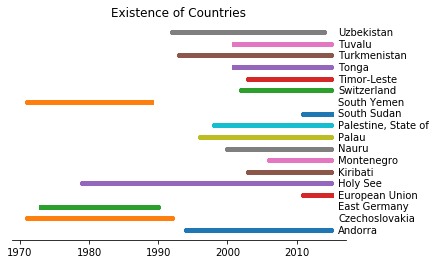

In [88]:
grouped = debates.groupby("name")


h = 1
for name, group in grouped:
    x = group["year"]
    y = np.empty(len(x))
    y.fill(h)
    
    i = round(h / len(grouped))
    #ax = axs[i]
    if len(x) < 23:
        plt.plot(x, y, linewidth=5)
        plt.annotate(name, xy=(2016,h-0.25))
        h += 1

#plt.gca().set_facecolor("lightgray")
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
plt.title("Existence of Countries")

plt.show()

Here we can see all the countries that have existed for less than half of the time we have data on. We can see that a few of these countries are recognizable. Apparently around 2012 the UN recognized the EU as an independent, speaking seat. Additionally Vatican City (the Holy See) is allowed to speak at the UN and is given its own country code. Since this country has existed for such a short amount of time we don’t have enough evidence of their speaking style.

## Voting Trends by Country

Here we analyze the voting trends of a few countries over time. We decided to focus on the power players in the UN, which means the United States, Russia, China, Germany, France and Japan.

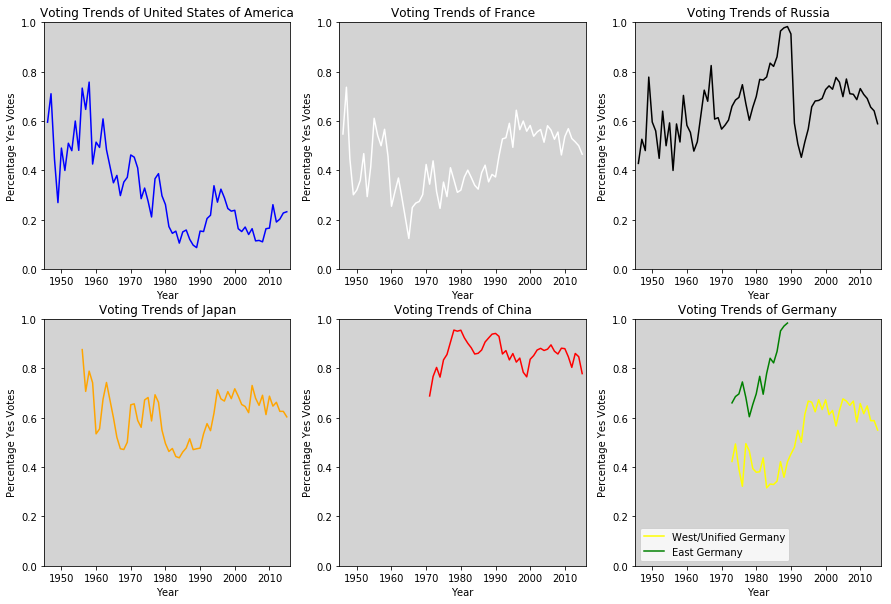

In [89]:
grouped = states.groupby("state_name")

# TODO Clean up code...
power_players = ["United States of America", "France", "Russia", "Japan", "China", "Germany"]
colors = ["blue", "white", "black", "orange", "red", "yellow"]

groups = [(player, grouped.get_group(player)) for player in power_players[:-1]]
groups.append(("Germany", (grouped.get_group("German Federal Republic"), grouped.get_group("German Democratic Republic"))))

fig, axs = plt.subplots(2, 3, figsize=(15,10))
for ax, (name, group), color in zip(axs.ravel(), groups, colors):
    if name != "Germany":
        x = group["year"]
        y = group["yes_votes"] / group["all_votes"]
    else:
        west = group[0].sort_values("year") # Necessary to remove glitch
        east = group[1]
        x = west["year"]
        x1 = east["year"]
        y = west["yes_votes"] / west["all_votes"]
        y1 = east["yes_votes"] / east["all_votes"]
    
    ax.plot(x, y, color=color)
    if name == "Germany": 
        ax.plot(x1, y1, color="green")
        ax.legend(["West/Unified Germany", "East Germany"])
    ax.set_facecolor("lightgray")
    ax.set_title("Voting Trends of "+name)
    ax.set_ylabel("Percentage Yes Votes")
    ax.set_xlabel("Year")
    
    ax.set_ylim(0, 1)
    ax.set_xlim(1945, 2016)
    
plt.show()

We can see that some countries tend to say yes more often while others are more conservative with their voting powers. China consistently votes yes while the US consistently votes no. We can also see a transition in how these countries tend to vote. The US used to vote much more positively, but within the last 30 years they have begun being more critical with their voting powers. We can also see a relationship between Russia and the Russia controlled East Germany around the end of the cold war in 1991. The two countries were voting yes in a similar fashion. After the cold war East Germany was merged with West Germany and Russia's voting trends make a nose dive, as they are probably retaliating.

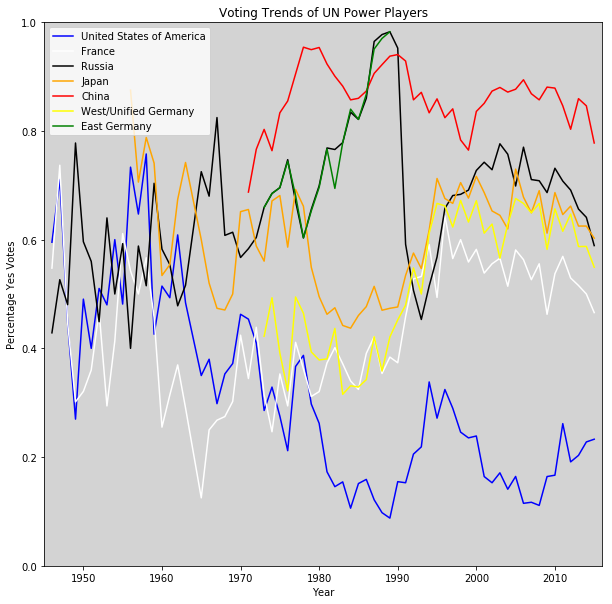

In [90]:
# Same as before, just same plot

grouped = states.groupby("state_name")

# TODO Clean up code...
power_players = ["United States of America", "France", "Russia", "Japan", "China", "Germany"]
colors = ["blue", "white", "black", "orange", "red", "yellow"]

groups = [(player, grouped.get_group(player)) for player in power_players[:-1]]
groups.append(("Germany", (grouped.get_group("German Federal Republic"), grouped.get_group("German Democratic Republic"))))

plt.figure(figsize=(10,10))
for (name, group), color in zip(groups, colors):
    if name != "Germany":
        x = group["year"]
        y = group["yes_votes"] / group["all_votes"]
    else:
        west = group[0].sort_values("year") # Necessary to remove glitch
        east = group[1]
        x = west["year"]
        x1 = east["year"]
        y = west["yes_votes"] / west["all_votes"]
        y1 = east["yes_votes"] / east["all_votes"]
    
    
    if name == "Germany":
        plt.plot(x, y, color=color, label="West/Unified Germany")
        plt.plot(x1, y1, color="green", label="East Germany")
    else:
        plt.plot(x, y, color=color, label=name)

plt.gca().set_facecolor("lightgray")

plt.title("Voting Trends of UN Power Players")
plt.ylabel("Percentage Yes Votes")
plt.xlabel("Year")
plt.legend()
plt.ylim(0, 1)
plt.xlim(1945, 2016)
plt.show()

### Analysis of Vote Types

In [91]:
resolution_types = ["colonization","human_rights","israel_palestine","disarmament","nuclear_weapons","economic_development"]
type_dict = {t: i+1 for i, t in enumerate(resolution_types)}
resolution_table = resolutions[["resolution"] + resolution_types]

In [92]:
rs = {}
for i, row in resolution_table.iterrows():
    p = row[row == 1]
    if len(p) > 0:
        rs[row["resolution"]] = p.index[0]
    else:
        rs[row["resolution"]] = "None"
resolutions["type"] = [rs.get(r) or "None" for r in resolutions["resolution"]]
votes["type"] = [rs.get(r) or "None" for r in votes["resolution"]]

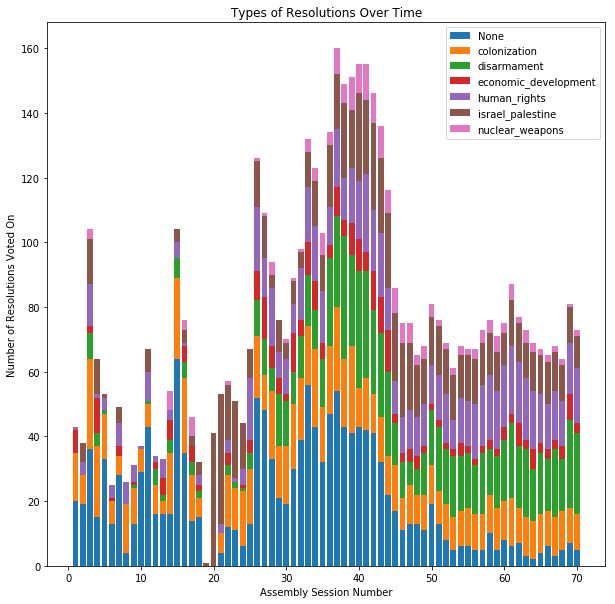

In [93]:
sessions = list(range(1,71))
prev = np.zeros(len(sessions))
plt.figure(figsize=(10,10))
for name, group in resolutions.groupby("type"):
    grouped = group.groupby("assembly_session")
    x = np.array(list(grouped.groups.keys()))
    y = grouped["assembly_session"].count().values
    real_x = sessions
    real_y = np.zeros(len(sessions))
    for i, l in enumerate(x):
        real_y[l-1] = y[i]
    plt.bar(real_x, real_y, bottom=prev, label=name)
    for i, l in enumerate(x):
        prev[l-1] += y[i]
plt.title("Types of Resolutions Over Time")
plt.legend()
plt.ylabel("Number of Resolutions Voted On")
plt.xlabel("Assembly Session Number")
plt.show()

type
colonization            954
disarmament             892
economic_development    302
human_rights            803
israel_palestine        859
nuclear_weapons         203
Name: type, dtype: int64


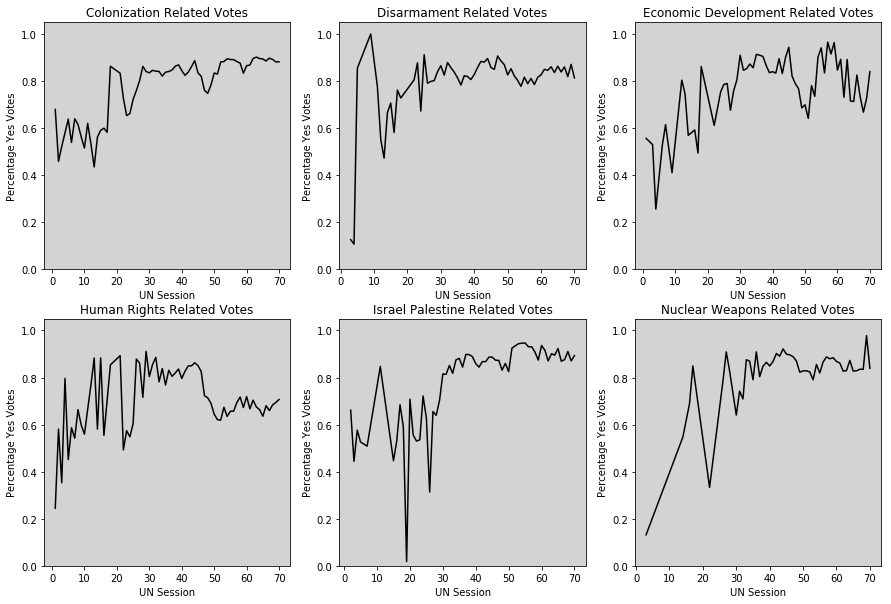

In [94]:
grouped = resolutions[resolutions["type"] != "None"].groupby("type")
print(grouped["type"].count()) # TODO Maybe remove this?

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, (name, group) in zip(axs.ravel(), grouped):
    if name == "None": continue
    group = group.groupby("assembly_session")
    x = group.groups.keys()
    yes = group["yes_votes"].sum()
    no = group["no_votes"].sum()
    abstain = group["abstain"].sum()
    y = yes / (yes + no + abstain)
    
    ax.plot(x,y,color="black")
    ax.set_facecolor("lightgray")
    ax.set_title(name.replace("_", " ").title() + " Related Votes")
    ax.set_ylabel("Percentage Yes Votes")
    ax.set_xlabel("UN Session")
    
    ax.set_ylim(0, 1.05)
    
plt.show()

Each major type of resolution starts off with very little support, but eventually gets up above 80% support. Interestingly human rights resolutions seem to lose support around the 50th session (1995) which is unique to those types of resolutions.

## Exploring Words

### Word Counts (Can we change this to "Every Word Counts"... get it?)

In [95]:
count_vect = CountVectorizer(max_df=.90, min_df=2, max_features=1000)
tfidf_vect = TfidfVectorizer(max_df=.90, min_df=2, max_features=1000)

counts = count_vect.fit_transform(debates["text"])
count_total = np.array(counts.sum(axis=0))[0]
count_vocab = count_vect.vocabulary_
count_feats = np.array(count_vect.get_feature_names())

tfidfs = tfidf_vect.fit_transform(debates["text"])
tfidf_vocab = tfidf_vect.vocabulary_
tfidf_feats = np.array(count_vect.get_feature_names())

In [96]:
max_indices = np.array(tfidfs.argmax(axis=1).T)[0]
max_words = tfidf_feats[max_indices]

In [97]:
important_counts = np.empty((0,2))
for doc, word in enumerate(max_words):
    index = count_vocab[word]
    count = counts[doc,index]
    important_counts = np.append(important_counts, np.array([[word, count]]), axis=0)
important_counts = pd.DataFrame(important_counts, columns=["word", "count"])

In [98]:
# Word counts of the most important words in each document...
important_counts.head()

,word,count
0,environment,11
1,keeping,10
2,co,12
3,democracy,9
4,african,17


### Tokenizing debates

In [158]:
def clean_debates(debates):
    '''
    This function takes in debates and removes stop words and ufeff which indicates the beginning of a file.
    In addition, the words are changed into lower case and returned as a list
    '''
    
    stop_word = stopwords.words('english')
    # stemming: removing parts of words to get the root word
    snowball = SnowballStemmer("english")
    
    debates['text_tokens'] = debates.text.map(lambda x: x.replace(u'\ufeff', ''))
    debates['text_tokens'] = debates.text.map(lambda x: x.replace(u'\n', ' '))
    debates['text_tokens'] = debates.text_tokens.map(lambda x: x.lower())
    debates['text_tokens'] = debates.text_tokens.map(lambda x: nltk.word_tokenize(x))
    # debates['text_tokens'] = debates.text_tokens.map(lambda x: [snowball.stem(t) for t in x])
    debates['text_tokens'] = debates.text_tokens.map(lambda x: [t for t in x if t not in stop_word])
    debates['text_tokens'] = debates.text_tokens.map(lambda x: [t for t in x if re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)])


    debates['text_tokens'] = debates.text_tokens.map(lambda x: [t for t in x if len(t) > 1])
    
    return debates
                                                                                                                
#     docs = []

#     for transcript in debates: 
#         if transcript is not None:
#             transcript = transcript.replace(u'\ufeff', '')
#             tokens = nltk.word_tokenize(transcript.lower())
#             tokens = [snowball.stem(token) for token in tokens]
#             tokens = [token for token in tokens if len(token) > 1]
#             docs.append([t.lower() for t in tokens if t not in stop_words and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)])
#     return docs

In [159]:
# For the purpose of the project and the sanity of my laptop, I have only pulled a few debates
sample_debates = clean_debates(sample_debates)
transcripts = sample_debates['text_tokens']
# words are cleaned for common words (stop words) and reduced to lowercase

### Bag of Words

In [161]:
# dictionary contains unique words and frequency
dictionary = corpora.Dictionary(transcripts)

# convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(transcript) for transcript in transcripts]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of debates: %d' % len(corpus))

Number of unique tokens: 12684
Number of debates: 100


### POS Tagging Debates

In [162]:
pos = [nltk.pos_tag(transcript) for transcript in transcripts[:5]]
# each token is tagged with a part of speech based on the Penn Tree Bank Tags
print(pos[2][:5])

[('allow', 'IN'), ('first', 'JJ'), ('sir', 'JJ'), ('congratulate', 'NN'), ('election', 'NN')]


## Exploring Entities

In [163]:
# Load English tokenizer, tagger, parser, NER and word vectors, etc.
nlp = en_core_web_sm.load()

# English model that is trained for English entities
nlp = spacy.load('en_core_web_sm')

doc = nlp(sample_debates['text'][0].replace('\n', ' '))

labels = [x.label_ for x in doc.ents]

# Unique Labels
print('Unique Labels from Transcript:')
for key, val in Counter(labels).items():
    print(key,'=', val)
# for label in Counter(labels):
#     print(label, Counter(label))

# Frequent tokens
print('\nFrequent Tokens')
items= [x.text for x in doc.ents]
print(Counter(items).most_common(3))

sentences = [x for x in doc.sents]
print('\nExmple Entities')
print([(X.text, X.label_) for X in doc.ents][0:3])

Unique Labels from Transcript:
ORG = 39
ORDINAL = 4
CARDINAL = 4
PERSON = 4
GPE = 30
DATE = 16
NORP = 7
LOC = 10
PRODUCT = 2
LAW = 2
EVENT = 1

Frequent Tokens
[('Organization', 9), ('States', 7), ('Comoros', 7)]

Exmple Entities
[('Assembly', 'ORG'), ('first', 'ORDINAL'), ('the Islamic Federal Republic of the Comoros', 'ORG')]


In [164]:
print('\nEntity Visualization')
# TODO: Idk how to fix this
for sentence in sentences[0:4]:
    displacy.render(nlp(str(sentence)), jupyter=True, style='ent')
# TO DO: SUPRESS WARNINGS
# TO DO: Fix output from overflowing argghhhh


Entity Visualization


/Users/egong/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/Users/egong/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


### Entity Analysis

As one might expect, entities that are relevant to the debates at the UN Organizations include NORP (Nationalities or religious or political groups), Law, Dates, etc. There is a relatively high number of Cardinal values. These are numerial values. This is due to the fact that the transcription is sectioned off and labeled numerically. 

Note: Some senties do not contain labeled entities which produces a warning occasionally.
Note: The values will vary due to the fact that 100 transcripts were chosen at random. 



## Exploring Topics

### Building LDA Model

In [165]:
# LDA Model (Latent Drichlet Allocation): generative stats model that explains sets of observations to be explained by unobserved groups  
num_topics = 3
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

lda_model = models.LdaModel(corpus=corpus, num_topics=3, passes=5, id2word=dictionary, eval_every=eval_every, minimum_probability=0)

In [166]:
print("LDA Model:")
 
for idx in range(num_topics):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)

LDA Model:
Topic #0: 0.010*"nations" + 0.010*"world" + 0.010*"international" + 0.009*"united" + 0.008*"countries" + 0.006*"peace" + 0.006*"people" + 0.005*"development" + 0.005*"security" + 0.005*"must"
Topic #1: 0.007*"united" + 0.006*"nations" + 0.006*"world" + 0.005*"countries" + 0.005*"states" + 0.004*"international" + 0.004*"people" + 0.004*"must" + 0.003*"human" + 0.003*"would"
Topic #2: 0.014*"nations" + 0.014*"united" + 0.012*"international" + 0.008*"countries" + 0.007*"world" + 0.007*"states" + 0.006*"development" + 0.006*"security" + 0.005*"peace" + 0.004*"economic"


Each line is a topic with individual topic terms and weights. However, there is a major amount of overlap in these transcripts as we can see. In order to dinstinguish between these topics, something like the term inverse document frequency might need to be applied. However, the concern is that important terms that do overlap may lose the meaning if ignored.

In [167]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/Users/egong/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.020337 -0.024961       1        1  49.988274
2     -0.040540  0.019989       2        1  43.193497
1      0.060877  0.004972       3        1   6.818228, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
634   Default  1610.000000         united  1610.000000  30.0000  30.0000
582   Default   777.000000         states   777.000000  29.0000  29.0000
663   Default  1238.000000          world  1238.000000  28.0000  28.0000
389   Default  1715.000000        nations  1715.000000  27.0000  27.0000
124   Default  1178.000000      countries  1178.000000  26.0000  26.0000
434   Default   705.000000         people   705.000000  25.0000  25.0000
665   Default   453.000000          would   453.000000  24.0000  24.0000
294   Default   477.000000          human   477.000000  23.0000  23.0000
386   Default   662.000000           must   662.000000  22.0000  22.0000
617   Default   257.000000          today   257.000000  21.0000  21.0000
435   Default   334.000000        peoples   334.000000  20.0000  20.0000
404   Default   381.000000            one   381.000000  19.0000  19.0000
321   Default  1554.000000  international  1554.000000  18.0000  18.0000
125   Default   450.000000        country   450.000000  17.0000  17.0000
1877  Default   137.000000        central   137.000000  16.0000  16.0000
38    Default   470.000000       assembly   470.000000  15.0000  15.0000
205   Default   170.000000           even   170.000000  14.0000  14.0000
2730  Default   112.000000            per   112.000000  13.0000  13.0000
176   Default   646.000000       economic   646.000000  12.0000  12.0000
265   Default   310.000000         global   310.000000  11.0000  11.0000
1714  Default   173.000000          trade   173.000000  10.0000  10.0000
268   Default   125.000000    governments   125.000000   9.0000   9.0000
2559  Default    94.000000           cent    94.000000   8.0000   8.0000
20    Default   188.000000        african   188.000000   7.0000   7.0000
1308  Default   129.000000           life   129.000000   6.0000   6.0000
581   Default   260.000000          state   260.000000   5.0000   5.0000
519   Default   196.000000      resources   196.000000   4.0000   4.0000
30    Default   626.000000           also   626.000000   3.0000   3.0000
412   Default   482.000000   organization   482.000000   2.0000   2.0000
666   Default   287.000000          years   287.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
634    Topic3    70.170715         united  1610.967773  -0.4481  -4.9808
663    Topic3    59.328865          world  1238.288696  -0.3528  -5.1487
268    Topic3    17.310148    governments   125.359093   0.7057  -6.3805
435    Topic3    27.596199        peoples   334.254639   0.1913  -5.9141
124    Topic3    51.163628      countries  1178.874146  -0.4517  -5.2967
389    Topic3    61.164433        nations  1715.564331  -0.6484  -5.1182
665    Topic3    31.689903          would   453.511627   0.0245  -5.7758
434    Topic3    38.847687         people   705.121826  -0.2132  -5.5721
294    Topic3    32.145370          human   477.077637  -0.0118  -5.7615
386    Topic3    36.055889           must   662.180420  -0.2249  -5.6467
205    Topic3    18.998930           even   170.044357   0.4939  -6.2874
1308   Topic3    16.768433           life   129.245789   0.6434  -6.4123
404    Topic3    25.486874            one   381.875671  -0.0214  -5.9936
1714   Topic3    18.528042          trade   173.161148   0.4506  -6.3125
321    Topic3    44.185078  international  1554.427246  -0.8749  -5.4434
176    Topic3    29.125835       economic   646.350525  -0.4141  -5.8601
38     Topic3    25.684563       assembly   470.129761  -0.2215  -5.9859
125    Topic3    25.276632        cou

The left panel, labeld Intertopic Distance Map, circles represent different topics and the distance between them. Similar topics appear closer and the dissimilar topics farther. The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus. An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.


The right panel, include the bar chart of the top 30 terms. When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics. Selecting each topic on the right, modifies the bar chart to show the "relevant" terms for the selected topic. Relevence is defined as in footer 2 and can be tuned by parameter  λ
 , smaller  λ
  gives higher weight to the term's distinctiveness while larger  λ
 s corresponds to probablity of the term occurance per topics.

Therefore, to get a better sense of terms per topic we'll use  λ
 =0.

Explanation by: https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization

### Evaluate LDA Model


In [168]:
df = pd.DataFrame()
df['transcripts'] = transcripts

# Seperate the data into two parts and see if the topics are similar
docs1 = df['transcripts'].apply(lambda l: l[:int(len(l)/2)])
docs2 = df['transcripts'].apply(lambda l: l[int(len(l)/2):])

# transform the data into bag of words
corpus1 = [dictionary.doc2bow(doc) for doc in docs1]
corpus2 = [dictionary.doc2bow(doc) for doc in docs2]

# Using the corpus LDA model tranformation
lda_corpus1 = lda_model[corpus1]
lda_corpus2 = lda_model[corpus2]

In [169]:
def get_doc_topic_dist(model, corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(lda_model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.asarray(vals)]
        if kwords:
            keys += [np.asarray(vals).argmax()]

    return np.asarray(top_dist), keys

In [170]:
top_dist1, _ = get_doc_topic_dist(lda_model, lda_corpus1)
top_dist2, _ = get_doc_topic_dist(lda_model, lda_corpus2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist1, top_dist2)]))

random_pairs = np.random.randint(0, len(df['transcripts']), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist1[i[0]].reshape(1, -1), top_dist2[i[1]].reshape(1, -1)) for i in random_pairs]))

Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.9875347
Inter similarity: cosine similarity between random parts (lower is better):
0.8138551


In [171]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [172]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

nations              0.010
world                0.010
international        0.010
united               0.009
countries            0.008
peace                0.006
people               0.006
development          0.005
security             0.005
must                 0.005
Topic 1 |---------------------

united               0.007
nations              0.006
world                0.006
countries            0.005
states               0.005
international        0.004
people               0.004
must                 0.004
human                0.003
would                0.003
Topic 2 |---------------------

nations              0.014
united               0.014
international        0.012
countries            0.008
world                0.007
states               0.007
development          0.006
security             0.006
peace                0.005
economic             0.004


### Topic Modeling Analysis
After exploring the concept of topics from the transcripts through numerical anlysis and data visualization, one can see that the topics overlap with common themes using words such as 'international', 'peace', etc. As a result, creating correlations between transcripts and countries would be difficult due to the lack of variation.

# Machine Learning

In [173]:
debates["country"] = pd.Categorical(debates["country"])
debates["code"] = debates["country"].cat.codes

In [174]:
# Split the data into training and test sets
train_x, test_x, train_y, test_y = train_test_split(tfidfs, debates["code"])

In [175]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [178]:
pred = clf.predict(test_x)

In [179]:
accuracy_score(test_y, pred)

0.42088438998401706

## t-SNS

In [203]:
lda_matrix = np.array([[y for (x,y) in lda_model[corpus[i]]] for i in range(len(corpus))])

# default metric is euclidians
tsne = TSNE(perplexity=30, metric='cosine')
tsne_embedding = tsne.fit_transform(lda_matrix, ) #TO DO: This causes an error...
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding['hue'] = lda_matrix.argmax(axis=1)

In [236]:
source = ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            colors = [all_palettes['Set1'][3][i] for i in tsne_embedding.hue],
            year = sample_debates.year,
            title = sample_debates.text_tokens,
            alpha = [0.9] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0]
            
        )
    )
hover_tsne = HoverTool(names=["sample_debates"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='t-SNE Representation')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="sample_debates")

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    year = data['year']
    title = data['title']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    
    source.trigger('change');
""")

slider = Slider(start=sample_debates.year.min(), end=sample_debates.year.max(), value=2015, step=1, title="Before year")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)

In [237]:
show(layout)

T-distributed Stochastic Neighbor Embedding is a machine learning algorithm. T-SNE allows us to identify hidden patterns in the data, explore and analyze the dataset by using a probabilistic dimensionality reduction and visualization. Typically when it is used for exploratory data analysis, there are typically clusters of colors representing patterns. The clusters are not very compact, but there is a clear difference between the 3 topics. There are some paramaters and possibly different ways to do preprocessing for more clear results. 


# Conclusion and Further Action

## Challenges

**Data:**  
After loading our data, we realized there some issues as we were cleaning our data.
- Countries have not stayed consistent in history.
    - They have broken apart, merged, and etc.
- UN representative also changes overtime 
    - Rhetoric of the transcript for each country will not be consistent
- The formal language at the UN constraints much of the variation that occurs in regular colloquium
- These transcriptions are translated
    -  There is evidence that meaning can be lost through language translation
    
From this, we concluded that it was not clear that the transcripts could provide insight on the country that was speaking. 

**Computer:**
- My computer cannot handle the entire dataset


## Additional Resources
- Similar Notebooks:
    - https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization
    
- LDA Explanation: https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation
- t-SNE Explanation: https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/
- Entity Labels: https://spacy.io/api/annotation
- Penn Tree Bank: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
